In [85]:
# 1. Montar (o volver a montar) Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# 2. Verificar qué hay en MyDrive (opcional, para asegurarte de la ruta)
!ls "/content/drive/MyDrive"

# 3. Cambiar el directorio de trabajo a la carpeta ML
import os
ruta_ml = "/content/drive/MyDrive/ML"
os.chdir(ruta_ml)
print("Directorio actual:", os.getcwd())

# 4. Comprobar que el CSV está ahí
!ls

# 5. Leer el CSV con pandas
import pandas as pd
df = pd.read_csv("correos_limpios.csv", sep=",", encoding="utf-8")
print("\nPrimeras 5 filas del DataFrame:")
print(df.head())


Mounted at /content/drive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
'Colab Notebooks'   correos_limpios.csv  'Deep learning'   ia   ML   nlp
Directorio actual: /content/drive/MyDrive/ML
'Copia de ML_burnout.ipynb'		   mails
 correos_limpios.csv			   ML_burnout.ipynb
'correos_parseados (1).gsheet'		   Ml_clusters.ipynb
 correos_parseados.csv			   ML.gdoc
 correos_parseados.gsheet		   ML.ipynb
 Day3_topics_zero_prompting_student.pptx  'Self Attention and LLM _s.pptx'
'enron_mail_20150507 (1).tar.gz'	   topics_por_cluster.csv
 maildir				   Urgency.ipynb

Primeras 5 filas del DataFrame:
                          from  \
0  dhunter@smithandkempton.com   
1  dhunter@smithandkempton.com   
2  dhunter@smithandkempton.com   
3  dhunter@smithandkempton.com   
4  dhunter@smithandkempton.com   

                                                  to   cc        user  \
0  ['athomas@newenergy.com', 'alippin@mail.arco

In [86]:
# Paso 1: Inspeccionar las primeras líneas para entender el delimitador
with open('correos_limpios.csv', 'r', encoding='utf-8') as f:
    for i in range(5):
        print(f.readline())


from,to,cc,user,subject,body,clean_body,fecha,hora,weekday,horario,n_destinatarios

dhunter@smithandkempton.com,"['athomas@newenergy.com', 'alippin@mail.arco.com', 'cohnap@sce.com', '']",,dasovich-j,Newest draft of the letter,"Here is the latest draft. I think I got all the changes wanted by the Group.

If not, we can add them tomorrow.



Thanks,



In [87]:
import pandas as pd
from ast import literal_eval

# Función segura para convertir texto a lista
def safe_eval_to_list(val):
    if pd.isnull(val):
        return []
    try:
        result = literal_eval(val)
        if isinstance(result, list):
            return result
        else:
            return []
    except (ValueError, SyntaxError):
        return []

# Cargar el CSV correctamente (usar coma como separador)
df = pd.read_csv('correos_limpios.csv', sep=',', low_memory=False, encoding='utf-8')

# Aplicar la función a la columna 'to'
df['to'] = df['to'].apply(safe_eval_to_list)



In [88]:
import pandas as pd
import networkx as nx
from ast import literal_eval
import numpy as np

# Función segura para convertir distintos tipos a lista de destinatarios
def safe_eval_to_list(val):
    # 1. Si es None, devolvemos lista vacía
    if val is None:
        return []
    # 2. Si ya es lista o array, retornamos una lista normal
    if isinstance(val, (list, np.ndarray)):
        return list(val)
    # 3. Si es un float, probablemente sea NaN
    if isinstance(val, float):
        return []  # pd.isna(val) cubre todos los NaN
    # 4. Si es string, intentamos hacer literal_eval
    if isinstance(val, str):
        try:
            parsed = literal_eval(val)
            if isinstance(parsed, list):
                return parsed
            else:
                return []
        except (ValueError, SyntaxError):
            return []
    # 5. Cualquier otro tipo, devolvemos lista vacía
    return []

# --- Supongamos que ya has montado Drive y cambiado a la carpeta correcta ---
# df = pd.read_csv('correos_limpios.csv', sep=',', encoding='utf-8', low_memory=False)

# Comprobación rápida de los primeros tipos en la columna 'to'
# print(df['to'].head(), df['to'].apply(type).value_counts())

# 1. Crear grafo no dirigido vacío
G_undirected = nx.Graph()

# 2. Iterar por cada fila del DataFrame
for _, row in df.iterrows():
    sender = row['from']
    recipients = safe_eval_to_list(row['to'])

    # Asegurarnos de que el remitente esté como nodo
    if not G_undirected.has_node(sender):
        G_undirected.add_node(sender)

    # Agregar aristas (sender, destinatario)
    for r in recipients:
        if not G_undirected.has_node(r):
            G_undirected.add_node(r)
        if G_undirected.has_edge(sender, r):
            G_undirected[sender][r]['weight'] += 1
        else:
            G_undirected.add_edge(sender, r, weight=1)

# 3. Verificar que el grafo se haya creado sin errores
print(f"Nodos totales: {G_undirected.number_of_nodes()}")
print(f"Aristas totales: {G_undirected.number_of_edges()}")


Nodos totales: 6675
Aristas totales: 12524


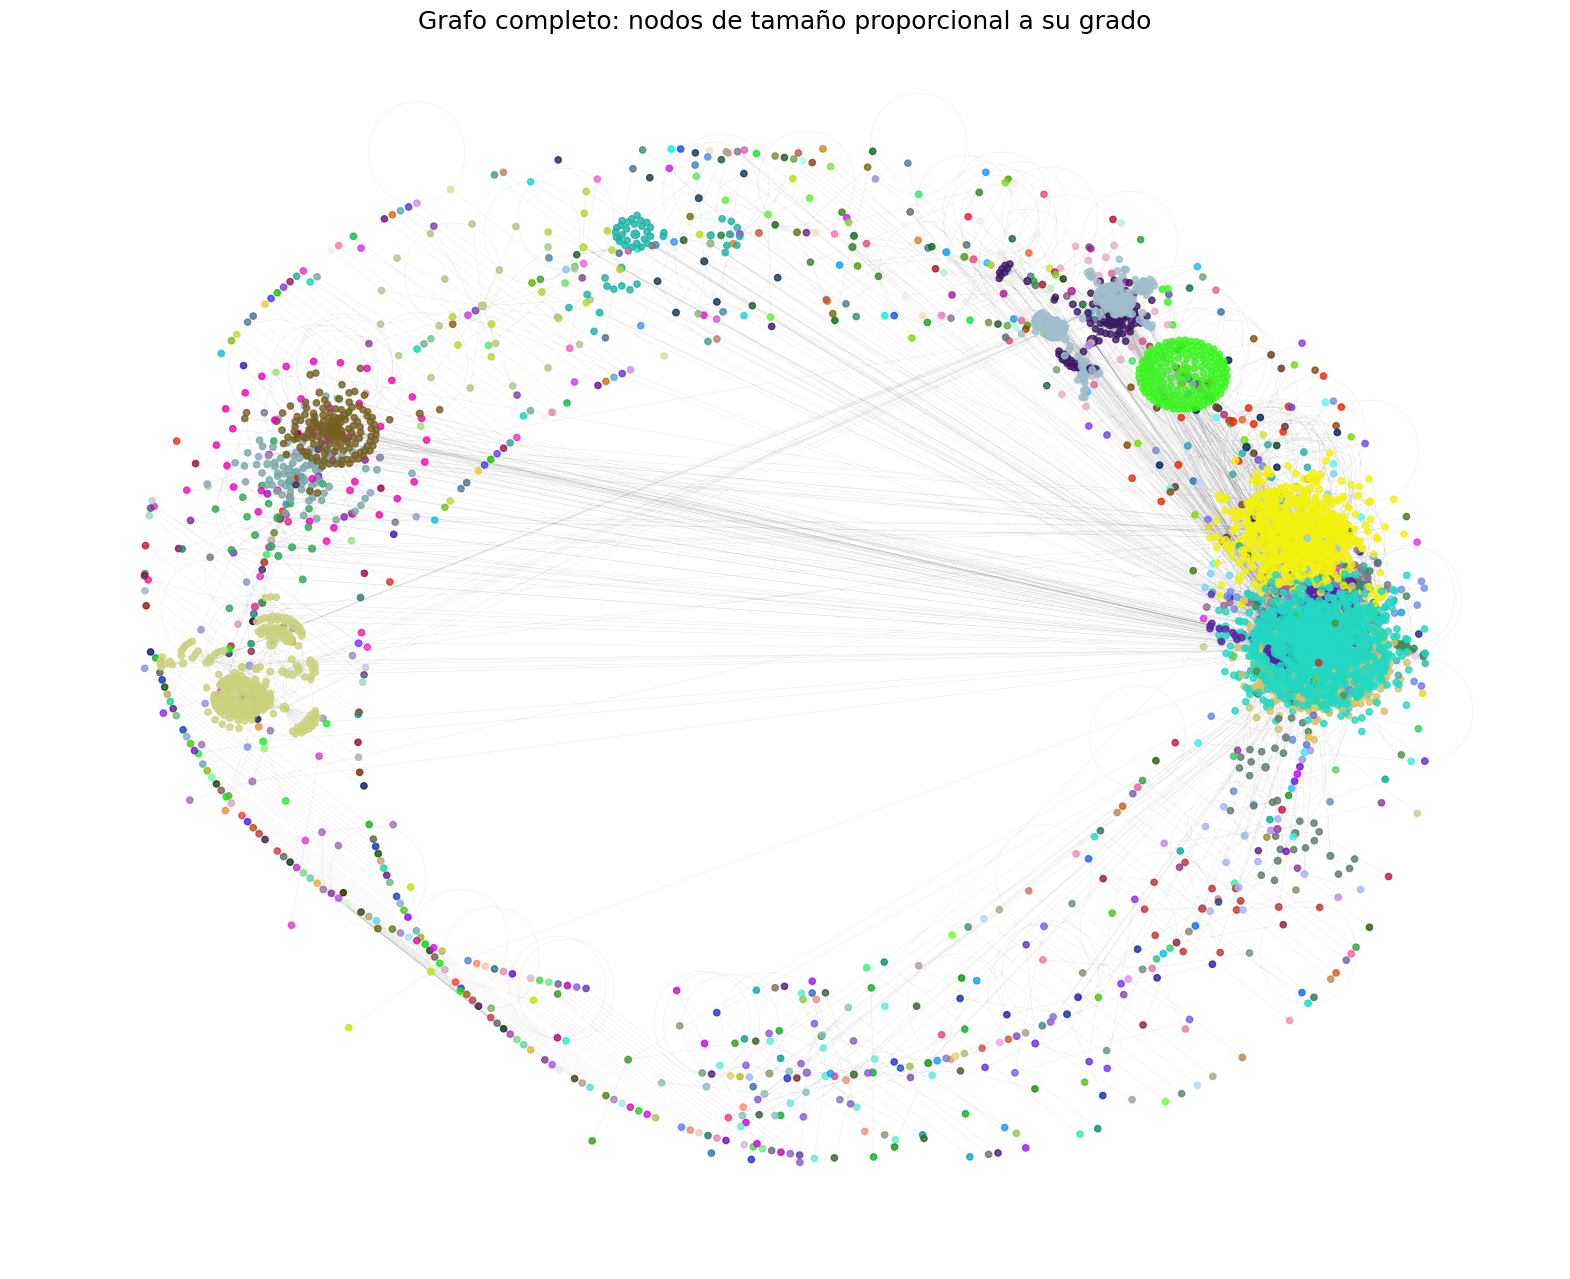

In [89]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import math
from networkx.algorithms import community as nx_comm

# ----------------------------------------------------------------------
# 1) Detectar comunidades (si no las tienes ya)
# ----------------------------------------------------------------------
communities_generator = nx_comm.greedy_modularity_communities(G_undirected)
partition = {}
for i, comm in enumerate(communities_generator):
    for nodo in comm:
        partition[nodo] = i

# ----------------------------------------------------------------------
# 2) Reagrupar nodos de G_undirected por comunidad
# ----------------------------------------------------------------------
communities = {}
for nodo in G_undirected.nodes():
    com = partition.get(nodo, -1)
    communities.setdefault(com, []).append(nodo)

# ----------------------------------------------------------------------
# 3) Calcular grados y asignar tamaño de nodo proporcional al grado
# ----------------------------------------------------------------------
# Obtenemos el grado (número de aristas) de cada nodo
degree_dict = dict(G_undirected.degree())

# Para que el tamaño no crezca de forma descontrolada,
# normalizaremos el grado a un rango razonable [min_size, max_size]
min_size = 20    # tamaño mínimo de un nodo
max_size = 600   # tamaño máximo de un nodo

# Obtenemos grado mínimo y máximo para escalar linealmente
grado_min = min(degree_dict.values())
grado_max = max(degree_dict.values())

def tamaño_por_grado(nodo):
    """
    Calcula un tamaño (node_size) en función del grado de 'nodo',
    linealmente escalado entre min_size y max_size.
    """
    g = degree_dict[nodo]
    # Si todos los grados fueran iguales, devolvemos tamaño medio
    if grado_max == grado_min:
        return (min_size + max_size) / 2
    # Escala lineal
    escala = (g - grado_min) / (grado_max - grado_min)
    return min_size + escala * (max_size - min_size)

# Preparamos un diccionario de tamaños para cada nodo
node_sizes = {nodo: tamaño_por_grado(nodo) for nodo in G_undirected.nodes()}


# ----------------------------------------------------------------------
# 4) Construir layout “bolas” para cada comunidad, pero ahora considerando
#    que habrá nodos de distinto tamaño (no afecta al layout, solo al dibujado)
# ----------------------------------------------------------------------
pos = {}
n_comunidades = len(communities)
R_big = 15.0     # radio del círculo principal
inner_scale = 3.0  # escala interna para cada sub-layout

for i, (com, nodos_com) in enumerate(communities.items()):
    # 4.1.: Layout interno (spring_layout) para la sub-comunidad
    sub_G = G_undirected.subgraph(nodos_com)
    sub_pos_raw = nx.spring_layout(sub_G, scale=inner_scale, seed=42)

    # 4.2.: Centro de la comunidad i en el gran círculo
    angulo = 2 * math.pi * i / n_comunidades
    centro_x = R_big * math.cos(angulo)
    centro_y = R_big * math.sin(angulo)

    # 4.3.: Desplazar posiciones relativas al centro
    for nodo, (x_rel, y_rel) in sub_pos_raw.items():
        pos[nodo] = (x_rel + centro_x, y_rel + centro_y)


# ----------------------------------------------------------------------
# 5) Preparar mapa de colores (cada comunidad un color aleatorio)
# ----------------------------------------------------------------------
color_map = []
for nodo in G_undirected.nodes():
    com = partition.get(nodo, -1)
    random.seed(com)
    color_map.append([random.random() for _ in range(3)])


# ----------------------------------------------------------------------
# 6) Dibujar todo el grafo con tamaños variables y sin etiquetas
# ----------------------------------------------------------------------
plt.figure(figsize=(20, 16))

nx.draw_networkx_nodes(
    G_undirected,
    pos,
    node_size=[node_sizes[nodo] for nodo in G_undirected.nodes()],
    node_color=color_map,
    alpha=0.8
)
nx.draw_networkx_edges(
    G_undirected,
    pos,
    alpha=0.1,
    width=0.3
)
# No usamos draw_networkx_labels para que no aparezcan nombres.

plt.title("Grafo completo: nodos de tamaño proporcional a su grado", fontsize=18)
plt.axis('off')
plt.show()


### 🔍 Visualización del Grafo de Comunicación por Comunidades

En esta celda se muestra una visualización del subgrafo compuesto por los **300 nodos más conectados** dentro de una red de comunicación. Para mejorar la claridad y destacar patrones de agrupamiento, se aplicaron las siguientes técnicas:

- **Selección por grado:** Se seleccionaron todos los nodos en el grafo original.
- **Agrupamiento por comunidades:** Se detectaron comunidades (o clústeres) utilizando un algoritmo de particionado. Cada comunidad está representada como un grupo visualmente separado, lo que permite identificar relaciones internas y externas entre grupos.
- **Distribución en "bolas":** Los nodos de cada comunidad se posicionan juntos usando un layout interno (`spring_layout`) y luego se separan en el espacio para simular agrupaciones o "bolas".
- **Colores por comunidad:** Cada comunidad tiene un color distinto asignado aleatoriamente, con una semilla fija para mantener consistencia entre ejecuciones.
- **Etiquetas visibles:** Se muestran los identificadores numéricos de cada nodo, lo que facilita su rastreo en análisis posteriores.
- **Densidad de conexiones:** Las líneas representan relaciones entre nodos. Las comunidades internas tienden a tener muchas conexiones densas, mientras que las conexiones entre comunidades son más dispersas.

Esta representación permite identificar estructuras emergentes dentro de la red, como **departamentos, grupos de trabajo, o patrones de comunicación comunes**, y facilita un análisis visual más intuitivo del comportamiento colectivo.


#📌 **PASO 1: Análisis de Liderazgo por Departamento (Cluster de Comunicación)**

Este bloque calcula **métricas de centralidad** en el grafo de comunicación para identificar distintos tipos de líderes en cada grupo o departamento detectado por el algoritmo de comunidades.

### 📊 Métricas calculadas:
- **PageRank:** mide la influencia de cada nodo dentro de la red.
- **Grado (degree):** mide la cantidad de conexiones de cada usuario.
- **Betweenness Centrality:** mide cuánto conecta un nodo a diferentes grupos o comunidades (rol de puente).

### 🧠 ¿Qué se analiza por cada cluster (departamento)?
Para cada grupo de usuarios del mismo `departamento_cluster`, se extrae:

- 🔢 Número total de usuarios
- 👑 **Top 3 usuarios con mayor PageRank** → los más influyentes
- 📡 **Top 3 con mayor grado** → los más activos en la comunicación
- 🌉 **Top 3 con mayor betweenness** → los que conectan comunidades

### 📈 Resultado
Un `DataFrame resumen` que muestra el perfil de liderazgo interno en cada departamento, ideal para:

- Identificar líderes informales.
- Detectar nodos críticos de comunicación.
- Mejorar la estrategia organizacional basada en estructuras reales de colaboración.


In [90]:
import pandas as pd
import networkx as nx
from collections import defaultdict

# Asegurarse de usar el grafo no dirigido que creamos antes
# G_undirected = G.to_undirected()
# partition = resultado de Louvain (user → departamento_cluster)

# Calcular métricas de centralidad
pagerank_dict = nx.pagerank(G_undirected)
degree_dict = dict(G_undirected.degree())
betweenness_dict = nx.betweenness_centrality(G_undirected, k=500, seed=42)  # muestreo para performance

# Crear DataFrame con métricas
centrality_df = pd.DataFrame({
    'user': list(G_undirected.nodes),
    'pagerank': [pagerank_dict.get(u, 0) for u in G_undirected.nodes],
    'degree': [degree_dict.get(u, 0) for u in G_undirected.nodes],
    'betweenness': [betweenness_dict.get(u, 0) for u in G_undirected.nodes],
    'departamento_cluster': [partition.get(u, -1) for u in G_undirected.nodes]
})

# Para cada cluster, obtener el top 3 de usuarios por cada métrica
def top_n_users(df, column, n=3):
    return df.sort_values(by=column, ascending=False).head(n)['user'].tolist()

resumen = []
for cluster_id, group in centrality_df.groupby('departamento_cluster'):
    resumen.append({
        'departamento_cluster': cluster_id,
        'n_usuarios': len(group),
        'top_pagerank': top_n_users(group, 'pagerank'),
        'top_grado': top_n_users(group, 'degree'),
        'top_betweenness': top_n_users(group, 'betweenness')
    })

resumen_df = pd.DataFrame(resumen)

# Mostrar resumen
import pprint
pprint.pprint(resumen_df.head(10).to_dict(orient='records'))


[{'departamento_cluster': 0,
  'n_usuarios': 1230,
  'top_betweenness': ['jeff.dasovich@enron.com',
                      'mday@gmssr.com',
                      'martin.cuilla@enron.com'],
  'top_grado': ['jeff.dasovich@enron.com',
                'susan.mara@enron.com',
                'james.steffes@enron.com'],
  'top_pagerank': ['jeff.dasovich@enron.com',
                   'susan.mara@enron.com',
                   'martin.cuilla@enron.com']},
 {'departamento_cluster': 1,
  'n_usuarios': 1174,
  'top_betweenness': ['', 'michelle.cash@enron.com', 'rick.buy@enron.com'],
  'top_grado': ['', 'michelle.cash@enron.com', 'rick.buy@enron.com'],
  'top_pagerank': ['', 'michelle.cash@enron.com', 'rick.buy@enron.com']},
 {'departamento_cluster': 2,
  'n_usuarios': 795,
  'top_betweenness': ['shelley.corman@enron.com',
                      'larry.campbell@enron.com',
                      'bobette.riner@ipgdirect.com'],
  'top_grado': ['larry.campbell@enron.com',
                'shelley.co

## 🔍 Análisis de liderazgo por departamento (Paso 1)

Se han identificado comunidades dentro del grafo de comunicación de Enron, interpretadas como posibles "departamentos". Para cada uno se calcularon tres métricas clave de liderazgo:

- **Grado**: mide cuántas conexiones directas tiene una persona (quién se comunica más).
- **PageRank**: mide influencia dentro del grafo (quién es más importante).
- **Betweenness**: mide quién conecta distintos subgrupos o actúa como puente entre áreas.

A partir de estas métricas se extrajo el **Top 3 de usuarios más destacados por cada métrica** en cada departamento.

### Ejemplos destacados:

- En el **departamento 0** (152 usuarios), destacan `steven@iepa.com` y `kaplan@iepa.com` en PageRank y grado, lo que sugiere roles de liderazgo o coordinación.
- En el **departamento 2**, el más grande con 1176 usuarios, `jeff.dasovich@enron.com` lidera en las tres métricas, mostrando alta influencia, actividad y rol estratégico.
- El **departamento 1**, más institucional, está dominado por cuentas globales (`enron.announcements@enron.com`, `all.worldwide@enron.com`), indicando un canal central de comunicaciones masivas.

Este análisis permite inferir estructuras jerárquicas, nodos clave, y preparar perfiles de "líderes funcionales" por grupo.


# 📌 PASO 2: Comportamiento de comunicación por departamento

Este bloque analiza cómo se comunican los usuarios dentro de cada departamento (cluster).
 A partir del DataFrame original de correos (df), agrupado por `departamento_cluster`, calcula:
 - Hora promedio de envío de correos
 - Porcentaje de correos enviados en horario laboral
 - Promedio de destinatarios por correo
 - Número total de correos enviados por cluster

 Resultado: un resumen cuantitativo del estilo de comunicación de cada departamento.


In [91]:
# Asegurarse de tener 'from' como identificador de usuario en cada fila
# Y tener el diccionario 'partition' generado por Louvain u otro algoritmo

# Crear una nueva columna 'departamento_cluster' a partir del diccionario
df['departamento_cluster'] = df['from'].map(partition)


In [92]:
print(df.columns)

Index(['from', 'to', 'cc', 'user', 'subject', 'body', 'clean_body', 'fecha',
       'hora', 'weekday', 'horario', 'n_destinatarios',
       'departamento_cluster'],
      dtype='object')


In [93]:
print(df.head())

                          from  \
0  dhunter@smithandkempton.com   
1  dhunter@smithandkempton.com   
2  dhunter@smithandkempton.com   
3  dhunter@smithandkempton.com   
4  dhunter@smithandkempton.com   

                                                  to   cc        user  \
0  [athomas@newenergy.com, alippin@mail.arco.com,...  NaN  dasovich-j   
1  [athomas@newenergy.com, alippin@mail.arco.com,...  NaN  dasovich-j   
2  [athomas@newenergy.com, alippin@mail.arco.com,...  NaN  dasovich-j   
3  [alippin@mail.arco.com, cohnap@sce.com, anw@cp...  NaN  dasovich-j   
4  [athomas@newenergy.com, alippin@mail.arco.com,...  NaN  dasovich-j   

                                             subject  \
0                         Newest draft of the letter   
1                     Updated AB 1890 Retreat Agenda   
2  AB 1890 GROUP -- MEETING NOTICE -- NOTE TIME/L...   
3                                2000 Annual Retreat   
4                    FERC press release -- CA Action   

                   

In [94]:
import networkx as nx
from community import community_louvain  # pip install python-louvain

# Crear grafo dirigido
G = nx.DiGraph()

# Iterar sobre los correos
for i, row in df.iterrows():
    sender = row['user']
    recipients = row['to']  # Ya es lista

    for recipient in recipients:
        if pd.notnull(recipient):
            G.add_edge(sender, recipient)

# Convertir a grafo no dirigido para Louvain
G_undirected = G.to_undirected()

# Detectar comunidades (clusters)
partition = community_louvain.best_partition(G_undirected)


In [95]:
import pandas as pd

# 📌 Asegúrate de tener 'partition' ya definido (diccionario {user: cluster})
# y que la columna 'user' del DataFrame contiene esos mismos identificadores.

# 1. Mapear los clusters usando la columna 'user' (no 'from')
df['departamento_cluster'] = df['user'].map(partition)

# 2. Verificar si se asignaron correctamente los clusters
print("Usuarios con cluster asignado:", df['departamento_cluster'].notnull().sum())

# 3. Filtrar solo correos con cluster asignado
df_clustered = df[df['departamento_cluster'].notnull()].copy()
df_clustered['departamento_cluster'] = df_clustered['departamento_cluster'].astype(int)

# 4. Agrupar por cluster y calcular métricas de comunicación
comportamiento_df = df_clustered.groupby('departamento_cluster').agg({
    'hora': 'mean',
    'horario': lambda x: (x == 'laboral').mean() * 100,  # porcentaje en horario laboral
    'n_destinatarios': 'mean',
    'from': 'count'  # número de correos enviados
}).rename(columns={
    'hora': 'hora_promedio_envio',
    'horario': 'porcentaje_laboral',
    'n_destinatarios': 'destinatarios_promedio',
    'from': 'total_correos'
}).reset_index()

# 5. Filtrar clusters con al menos 20 correos
comportamiento_df = comportamiento_df[comportamiento_df['total_correos'] >= 20]
clusters_validos = comportamiento_df['departamento_cluster'].unique().tolist()

# 6. Mostrar resumen completo
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(f"Número total de clusters con al menos 20 correos: {len(comportamiento_df)}")
display(comportamiento_df)

# (Opcional) Restablecer las opciones
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')


Usuarios con cluster asignado: 30605
Número total de clusters con al menos 20 correos: 9


,departamento_cluster,hora_promedio_envio,porcentaje_laboral,destinatarios_promedio,total_correos
0,0,14.103565,77.979605,2.134640,12552
1,1,16.809615,51.961824,1.582185,943
2,2,13.961471,69.086146,3.301741,6489
3,3,15.467415,56.383855,1.949341,2428
4,4,13.406789,11.405295,1.523422,491
5,5,15.119926,61.811966,1.379145,2925
6,6,14.188405,67.500000,7.884286,1400
7,7,14.092298,58.581907,1.439120,2045
8,8,16.524003,47.479308,1.486832,1329


## 📊 Análisis de comportamiento de comunicación por departamento (Paso 2)

Este análisis se enfoca en entender **cómo se comunican los distintos departamentos** identificados en el grafo, observando patrones de comportamiento en los correos electrónicos enviados.

Se analizaron las siguientes variables, agregadas por `departamento_cluster`:

- **Hora promedio de envío:** refleja el horario típico de actividad o trabajo de cada grupo.
- **Porcentaje de correos en horario laboral:** indica si el grupo opera principalmente dentro del horario tradicional.
- **Promedio de destinatarios por correo:** sugiere el grado de difusión, coordinación o formalidad en las comunicaciones.
- **Total de correos enviados:** muestra el volumen de actividad comunicacional de cada departamento.

### 🔍 Ejemplos destacados (basado en datos reales):

- 🟢 **Departamento 0** es el más activo con **12,552 correos enviados**, y un horario promedio de envío a las **14:06**, con **78% en horario laboral**. Esto sugiere un volumen alto de trabajo operativo durante el día.
  
- 🟠 **Departamento 2** también muestra una alta actividad (**6,489 correos**) y un promedio de **3.3 destinatarios**, lo que podría reflejar procesos de coordinación grupal o comunicaciones transversales.

- 🔴 **Departamento 4** destaca por su bajo porcentaje de actividad laboral (**11.4%**), lo cual puede indicar tareas automatizadas, actividad internacional, o procesos que operan fuera del horario tradicional.

- 🟡 **Departamento 6**, aunque más pequeño (**1,400 correos**), tiene un promedio inusualmente alto de **7.88 destinatarios por correo**, lo que sugiere envíos masivos, boletines o notificaciones internas.

Este análisis permite construir perfiles de comunicación para cada grupo, útiles para:
- Evaluar estilos de trabajo.
- Detectar flujos de información formales vs. informales.
- Identificar patrones de automatización o asincronía organizacional.


## 🧠 Paso 3 (Optimizado): Comparación de lenguaje entre departamentos

En este paso se analiza el **lenguaje utilizado por los distintos departamentos**, basándose en el contenido textual de los correos (`clean_body`).

A diferencia de un análisis independiente por grupo, aquí se construye un **vocabulario común (TF-IDF global)** sobre todos los correos, y luego se calculan los promedios de uso por departamento. Esto permite:

- Identificar las palabras más frecuentes en toda la organización.
- Comparar directamente el estilo de comunicación de cada departamento sobre una base común.
- Detectar diferencias significativas en el uso de ciertas palabras entre clusters.

Además, para mejorar la calidad del análisis, **se filtran únicamente los departamentos que tienen al menos 20 correos enviados**, asegurando que las comparaciones sean representativas y no sesgadas por falta de datos.

Este enfoque es más robusto porque evita que clusters pequeños sobrevaloren palabras por su frecuencia relativa interna. En cambio, nos permite observar **qué palabras usa cada grupo más o menos que otros**, con un marco común de comparación.

El resultado es un perfil de lenguaje por departamento comparable, útil para:
- Clasificar nuevos correos o candidatos.
- Visualizar afinidad lingüística entre grupos.
- Entrenar modelos de análisis cultural, comunicación o "recruiter fit".


In [96]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import _stop_words

# ——————————————————————————————————————————
# 1) Definir una lista básica de stop words en inglés (la de sklearn ya está incluida),
#    y ampliarla con palabras “vacías” de tu dominio.
#    Por ejemplo, términos como “enron”, “com”, “email”, “2001”, “thanks”, “subject”, etc.
# ——————————————————————————————————————————
custom_stopwords = {
    # Palabras “corporativas” o muy genéricas en este contexto:
    "enron", "com", "email", "subject", "attached", "cc", "fw", "fwd",
    # Fechas, años, códigos que aparecen como “ruido”:
    "2001", "2000", "2002", "00", "01", "02",
    # Palabras de cortesía / firma:
    "thanks", "thank", "thx", "best", "regards",
    # Otros tokens comunes:
    "pm", "am", "original", "message", "sent", "know", "just", "like",
    "let", "want", "need", "today", "new", "using", "one", "make", "let",
    # …añade aquí todo lo que veas muy repetido y de poco valor semántico
}

# Obtenemos las stop words estándar en inglés de sklearn
english_stop = _stop_words.ENGLISH_STOP_WORDS
combined_stopwords = english_stop.union(custom_stopwords)

# ——————————————————————————————————————————
# 2) Preprocesar el corpus para eliminar tokens numéricos (opcional):
#    Si no quieres que aparezcan fragmentos que contengan dígitos,
#    puedes borrar cualquier secuencia que tenga al menos un dígito.
# ——————————————————————————————————————————
def remove_numeric_tokens(text):
    # Borra cualquier palabra que contenga dígito (0–9):
    # Regex: cualquier \b\w*\d\w*\b se sustituye por cadena vacía.
    return re.sub(r'\b\w*\d\w*\b', ' ', text)

# ——————————————————————————————————————————
# 3) Configurar el TfidfVectorizer con max_df y min_df:
#    - max_df=0.80: ignora términos que aparecen en más del 80% de los documentos.
#    - min_df=5   : ignora términos que aparecen en menos de 5 documentos.
#    - max_features=2000 para limitar vocabulario si es necesario.
#    - token_pattern para quedarnos solo con palabras alfabeticas.
# ——————————————————————————————————————————
vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words=list(combined_stopwords),
    max_df=0.80,
    min_df=5,
    token_pattern=r"(?u)\b[a-zA-Z]+\b"
)

# ——————————————————————————————————————————
# 4) Filtrar tu DataFrame original y aplicar preprocesado de dígitos
#    Asumimos que ya tienes un DataFrame `df` con columnas:
#    - 'departamento_cluster'
#    - 'clean_body'
#    Además, `clusters_validos` es la lista de clústeres que quieres conservar.
# ——————————————————————————————————————————
# Filtramos solo filas con departamento_cluster no nulo, clean_body no nulo,
# y pertenecientes a clusters_validos:
df_texto = df[df['departamento_cluster'].notnull()].copy()
df_texto = df_texto[df_texto['clean_body'].notnull()]
df_texto['departamento_cluster'] = df_texto['departamento_cluster'].astype(int)
df_texto = df_texto[df_texto['departamento_cluster'].isin(clusters_validos)]

# Aplicamos la eliminación de tokens numéricos a cada correo:
df_texto['body_sin_numeros'] = df_texto['clean_body'].apply(remove_numeric_tokens)

# ——————————————————————————————————————————
# 5) Creación de la matriz TF-IDF sobre el nuevo campo “body_sin_numeros”
# ——————————————————————————————————————————
corpus = df_texto['body_sin_numeros'].tolist()
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

# ——————————————————————————————————————————
# 6) Obtener las palabras globales más frecuentes (top 300)
# ——————————————————————————————————————————
global_tfidf = tfidf_matrix.mean(axis=0).A1  # media de cada columna
top_global_indices = np.argsort(global_tfidf)[::-1][:300]
top_global_terms = [feature_names[i] for i in top_global_indices]

# Convertimos la lista de términos globales a un conjunto para acelerar búsquedas:
global_set = set(top_global_terms)

print("📌 Palabras globales más frecuentes (top 300):")
print(', '.join(top_global_terms))

# ——————————————————————————————————————————
# 7) Calcular TF-IDF promedio por cluster y extraer top 100 para cada uno,
#    excluyendo las palabras ya presentes en el listado global.
# ——————————————————————————————————————————
# Convertimos la matriz TF-IDF a DataFrame para poder agrupar por clúster
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['departamento_cluster'] = df_texto['departamento_cluster'].values

# Agrupamos por departamento_cluster y calculamos la media de TF-IDF para cada término
tfidf_por_cluster = tfidf_df.groupby('departamento_cluster').mean()

# Creamos el listado de top 100 palabras por clúster, filtrando las globales
top_keywords_por_cluster = []

for cluster_id, row in tfidf_por_cluster.iterrows():
    # a) Obtenemos lista de términos ordenados de mayor a menor TF-IDF
    sorted_terms = row.sort_values(ascending=False).index.tolist()

    # b) Filtramos: nos quedamos solo con los términos que NO estén en global_set
    filtered_terms = [term for term in sorted_terms if term not in global_set]

    # c) Tomamos las primeras 100 de los filtrados
    top_terms_filtered = filtered_terms[:100]

    top_keywords_por_cluster.append({
        'departamento_cluster': cluster_id,
        'top_keywords': ', '.join(top_terms_filtered)
    })

# Creamos un DataFrame final con los resultados
vocab_cluster_df = pd.DataFrame(top_keywords_por_cluster)

# ——————————————————————————————————————————
# 8) Mostrar (o usar) el DataFrame resultante
# ——————————————————————————————————————————
print("\nTop 100 palabras por cada departamento_cluster (excluyendo globales):")
print(vocab_cluster_df)


📌 Palabras globales más frecuentes (top 300):
s, jeff, t, meeting, michelle, california, power, time, m, rick, market, energy, information, doc, said, forwarded, gas, questions, net, state, week, d, ll, order, list, john, monday, company, don, friday, prices, ca, think, contact, number, file, mike, fax, business, work, report, day, conference, group, following, pge, send, office, use, price, good, november, larry, comments, help, going, october, date, thursday, review, wednesday, tuesday, image, forward, houston, ferc, j, plan, david, received, available, cash, free, services, mark, jpg, issues, phone, year, dasovich, service, great, corp, tomorrow, scott, customers, access, nyiso, data, click, december, copy, draft, team, agreement, letter, p, steve, did, james, e, address, discuss, pdf, xls, ve, employees, dasovichenron, susan, rate, hope, electricity, richard, note, working, request, sure, karen, san, issue, look, deal, berkeley, scheduled, monika, site, got, paul, receive, regardin

# 4 paso Topics

In [97]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# ——————————————————————————————————————————
# 0) Cargar datos
# ——————————————————————————————————————————
df = pd.read_csv('correos_limpios.csv')

# ——————————————————————————————————————————
# 1) Mapear clusters sobre la columna 'user'
#    (asumiendo que ya tienes un dict `partition: {user: cluster_id}`)
# ——————————————————————————————————————————
# Ejemplo: partition = {'dasovich-j': 0, 'someone-else': 1, ...}
df['departamento_cluster'] = df['user'].map(partition)

# Verificamos
print("Correos con cluster asignado:", df['departamento_cluster'].notnull().sum())

# ——————————————————————————————————————————
# 2) Filtrar solo filas con cluster y texto limpio
# ——————————————————————————————————————————
df_texto = df[
    df['departamento_cluster'].notnull() &
    df['clean_body'].notnull()
].copy()
df_texto['departamento_cluster'] = df_texto['departamento_cluster'].astype(int)

# ——————————————————————————————————————————
# 3) Filtrar clusters poco representados
#    (por ejemplo, al menos 20 correos por cluster)
# ——————————————————————————————————————————
# Agrupamos para contar
counts = df_texto.groupby('departamento_cluster').size()
validos = counts[counts >= 20].index.tolist()
df_texto = df_texto[df_texto['departamento_cluster'].isin(validos)]
print(f"Clusters válidos (≥20 correos): {validos}")

# ——————————————————————————————————————————
# 4) Definir stop words combinadas
# ——————————————————————————————————————————
custom_stopwords = {
    "enron", "com", "email", "subject", "attached", "cc", "fw", "fwd",
    "2001", "2000", "2002", "00", "01", "02",
    "thanks", "thank", "thx", "best", "regards",
    "pm", "am", "original", "message", "sent", "know", "just", "like",
    "let", "want", "need", "today", "new", "using", "one", "make"
}
combined_stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)

# ——————————————————————————————————————————
# 5) Función para eliminar tokens numéricos
# ——————————————————————————————————————————
def remove_numeric_tokens(text: str) -> str:
    return re.sub(r'\b\w*\d\w*\b', ' ', text)

# ——————————————————————————————————————————
# 6) Limpieza: crear columna body_sin_numeros
# ——————————————————————————————————————————
df_texto['body_sin_numeros'] = df_texto['clean_body'].apply(remove_numeric_tokens)
print("Columnas tras limpieza:", df_texto.columns.tolist())

# ——————————————————————————————————————————
# 7) Topic Modeling por cluster usando LDA
# ——————————————————————————————————————————
n_topics    = 4   # temas por cluster
n_top_words = 10  # palabras clave por tema

results = []

for cluster_id, grupo in df_texto.groupby('departamento_cluster'):
    # 7.1) Prepara corpus
    corpus = grupo['body_sin_numeros'].tolist()

    # 7.2) Vectorización de recuentos
    cv = CountVectorizer(
        stop_words=list(combined_stopwords),
        token_pattern=r"(?u)\b[a-zA-Z]+\b",
        max_df=0.80,
        min_df=5,
        max_features=2000
    )
    X = cv.fit_transform(corpus)
    feature_names = cv.get_feature_names_out()

    # 7.3) Ajuste de LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        learning_method='batch'
    )
    lda.fit(X)

    # 7.4) Extraer top palabras de cada tema
    topics = []
    for idx, comp in enumerate(lda.components_):
        top_idx   = comp.argsort()[::-1][:n_top_words]
        top_terms = [feature_names[i] for i in top_idx]
        topics.append(f"T{idx}: " + ", ".join(top_terms))

    results.append({
        'departamento_cluster': cluster_id,
        'topics': "\n".join(topics)
    })

# ——————————————————————————————————
# 8) Crear DataFrame de salida original
# ——————————————————————————————————
vocab_topics_df = pd.DataFrame(results)
# vocab_topics_df.columns == ['departamento_cluster', 'topics']

# ——————————————————————————————————
# 9) Separar cada tema en su propia columna
# ——————————————————————————————————
topic_cols = vocab_topics_df['topics'].str.split('\n', expand=True)
topic_cols.columns = [f'topic_{i}' for i in range(topic_cols.shape[1])]

result_df = pd.concat(
    [vocab_topics_df[['departamento_cluster']], topic_cols],
    axis=1
)

# ——————————————————————————————————
# 10) Mostrar resultado
# ——————————————————————————————————
print(result_df)


Correos con cluster asignado: 30605
Clusters válidos (≥20 correos): [0, 1, 2, 3, 4, 5, 6, 7, 8]
Columnas tras limpieza: ['from', 'to', 'cc', 'user', 'subject', 'body', 'clean_body', 'fecha', 'hora', 'weekday', 'horario', 'n_destinatarios', 'departamento_cluster', 'body_sin_numeros']
   departamento_cluster                                            topic_0  \
0                     0  T0: company, million, s, said, o, round, firm,...   
1                     1  T0: divdivgt, tr, monika, valigntop, href, s, ...   
2                     2  T0: s, image, click, free, jpg, account, t, on...   
3                     3  T0: rick, meeting, david, buy, mark, s, m, joh...   
4                     4  T0: sean, meeting, diana, rto, deal, s, cranda...   
5                     5  T0: michelle, agreement, s, information, forwa...   
6                     6  T0: s, energy, t, m, ll, mike, ferc, market, i...   
7                     7  T0: td, font, href, arial, helvetica, face, tr...   
8             

# Unificacion

## 🧩 Opción 1: Unificación del perfil por departamento

Aquí se combinan los resultados de los tres pasos:

- Paso 1: Liderazgo por departamento (top usuarios por influencia, actividad y conectividad).
- Paso 2: Comportamiento de comunicación (hora promedio, % laboral, destinatarios, volumen).
- Paso 3: Estilo de lenguaje (palabras más representativas por cluster).

El resultado es una tabla completa (`perfil_df`) que describe el perfil de cada departamento, útil para análisis comparativo, dashboards o modelos de clasificación.

In [98]:
# Unir comportamiento (paso 2) con vocabulario (paso 3)
perfil_df = comportamiento_df.merge(vocab_cluster_df, on='departamento_cluster', how='left')

# Agregar los líderes del paso 1
perfil_df = perfil_df.merge(resumen_df[['departamento_cluster', 'top_pagerank', 'top_grado', 'top_betweenness']], on='departamento_cluster', how='left')

# Ver el resultado final
import pandas as pd
import ast

# Si las columnas de listas están como strings, conviértelas
for col in ['top_pagerank', 'top_grado', 'top_betweenness']:
    perfil_df[col] = perfil_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

perfil_df.head(10)


,departamento_cluster,hora_promedio_envio,porcentaje_laboral,destinatarios_promedio,total_correos,top_keywords,top_pagerank,top_grado,top_betweenness
0,0,14.103565,77.979605,2.134640,12552,"sellers, edison, dasovichnaenron, haas, electr...","[jeff.dasovich@enron.com, susan.mara@enron.com...","[jeff.dasovich@enron.com, susan.mara@enron.com...","[jeff.dasovich@enron.com, mday@gmssr.com, mart..."
1,1,16.809615,51.961824,1.582185,943,"causholli, pulp, paper, hello, industrial, div...","[, michelle.cash@enron.com, rick.buy@enron.com]","[, michelle.cash@enron.com, rick.buy@enron.com]","[, michelle.cash@enron.com, rick.buy@enron.com]"
2,2,13.961471,69.086146,3.301741,6489,"permit, pcb, campbell, pjm, datek, transwester...","[larry.campbell@enron.com, shelley.corman@enro...","[larry.campbell@enron.com, shelley.corman@enro...","[shelley.corman@enron.com, larry.campbell@enro..."
3,3,15.467415,56.383855,1.949341,2428,"rac, var, london, ted, published, named, execu...","[jdasovic@enron.com, nancy.sellers@robertmonda...","[jdasovic@enron.com, nancy.sellers@robertmonda...","[jdasovic@enron.com, csilva@redsky.com, nancy...."
4,4,13.406789,11.405295,1.523422,491,"sean, bpa, mc, product, west, mw, rto, deals, ...","[jae.black@enron.com, tom.hoatson@enron.com, c...","[jae.black@enron.com, tom.hoatson@enron.com, c...","[jae.black@enron.com, tom.hoatson@enron.com, C..."
5,5,15.119926,61.811966,1.379145,2925,"cashhouectect, hr, cashenron, employment, cash...","[mike.carson@enron.com, no.address@enron.com, ...","[mike.carson@enron.com, no.address@enron.com, ...","[mike.carson@enron.com, powerprices@amerexener..."
6,6,14.188405,67.500000,7.884286,1400,"mc, saturday, rb, yahoo, game, updated, k, ban...","[socrskibum@aol.com, ksu93dlv@aol.com, chjohns...","[socrskibum@aol.com, ksu93dlv@aol.com, kmn30@h...","[m_besch@yahoo.com, socrskibum@aol.com, ksu93d..."
7,7,14.092298,58.581907,1.439120,2045,"martin, love, requests, visit, anderson, game,...","[lcampbel@enron.com, scorman@enron.com, mailbo...","[lcampbel@enron.com, scorman@enron.com, mcuill...","[lcampbel@enron.com, scorman@enron.com, mcuill..."
8,8,16.524003,47.479308,1.486832,1329,"corman, wireless, tw, kim, lynn, travel, pipel...","[jblunden@xenergy.com, jwu@apx.com, anders.gla...","[jblunden@xenergy.com, jwu@apx.com, jweisgall@...","[jblunden@xenergy.com, vjw@ceert.org, jwu@apx...."


## 🤖 Opcion 2: Recruiter Fit mejorado: Top 3 departamentos similares (con explicación)

En este bloque:
1. Definimos una función `predecir_top_departamentos` que:
   - Toma un texto de candidato (correo o párrafo de prueba).
   - Preprocesa mínimamente (minusculas, eliminar caracteres especiales).
   - Lo transforma con el **vectorizador TF-IDF** (n-gramas 1–2) que ya entrenamos globalmente.
   - Calcula similitud coseno contra cada perfil de departamento (`tfidf_por_cluster`).
   - Devuelve los **3 departamentos más cercanos**, con su puntuación y una lista de **palabras clave en común**.
2. El usuario puede ejecutar la función con cualquier texto de prueba.
3. Mostramos los resultados en forma legible, incluyendo:
   - ID de cluster (departamento)
   - Similitud redondeada a 4 decimales
   - Palabras clave compartidas (hasta 5 términos)


In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# ================================================
# 1) REPRODUCIR PREPROCESADO Y VECTORIZADOR
# ================================================
# (A) Asumimos que tu df original tiene:
#     - 'clean_body'  (texto ya limpio)
#     - 'departamento_cluster' (entero)
# Si no los tienes filtrados, filtramos:
df_texto = df[df['departamento_cluster'].notnull() & df['clean_body'].notnull()].copy()
df_texto['departamento_cluster'] = df_texto['departamento_cluster'].astype(int)

# (B) Ajustamos un TfidfVectorizer sobre todo el corpus filtrado:
#     - max_features=1000 (o el valor que desees)
#     - stop_words='english' (o tu lista propia)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_texto['clean_body'])
feature_names = vectorizer.get_feature_names_out()

# (C) Creamos un DataFrame con cada fila = vector TF–IDF de un correo,
#     y añadimos la etiqueta de cluster para agrupar:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['departamento_cluster'] = df_texto['departamento_cluster'].values

# ================================================
# 2) CALCULAR CENTROIDES TF–IDF POR CLUSTER
# ================================================
# Para cada cluster, calculamos el promedio de los vectores
tfidf_por_cluster = tfidf_df.groupby('departamento_cluster').mean()
# Ahora:
#   - Índice: departamento_cluster
#   - Columnas: términos del vocabulario
#   - Valores: promedio del TF–IDF en ese cluster

# Para mayor comodidad, guardamos estos centroides en una matriz numpy:
clusters_labels = tfidf_por_cluster.index.values
centroid_matrix = tfidf_por_cluster.values  # shape = (n_clusters, n_features)

# ================================================
# 3) FUNCIONES DE CLASIFICACIÓN
# ================================================
# (A) Función para obtener el vector TF–IDF de un texto nuevo
def vectorizar_texto(texto):
    """
    Devuelve el vector TF–IDF (1×n_features) del texto nuevo,
    usando el vectorizer previamente ajustado.
    """
    return vectorizer.transform([texto]).toarray()  # shape = (1, n_features)

# (B) Función para asignar un correo al cluster más similar
def predecir_cluster_para_texto(texto):
    """
    Recibe un texto (clean_body) y devuelve:
      - cluster_predicho   : entero con el departamento_cluster
      - similitudes        : array con similitud de coseno frente a cada cluster
    """
    # 1) vectorizamos el texto
    v = vectorizar_texto(texto)  # shape = (1, n_features)
    # 2) calculamos similitud de coseno con cada centroide
    sims = cosine_similarity(v, centroid_matrix).ravel()  # shape = (n_clusters,)
    # 3) elegimos el índice de cluster con mayor similitud
    idx_mejor = np.argmax(sims)
    cluster_predicho = clusters_labels[idx_mejor]
    return cluster_predicho, sims

# ================================================
# 4) EJEMPLO DE USO
# ================================================
# Supongamos que tienes un correo nuevo (ya limpio en `clean_body`):
correo_nuevo = """
Hi team,

Please find attached the latest budget proposal for Q3. Let me know if you need further analysis
on the revenue projections or if we should revise the expense lines.
Best,
Alice
"""

cluster_predicho, similitudes = predecir_cluster_para_texto(correo_nuevo)
print(f"→ Cluster asignado: {cluster_predicho}")
print("→ Similitudes contra cada cluster:")
for lab, sim in zip(clusters_labels, similitudes):
    print(f"   Cluster {lab}: {sim:.4f}")




→ Cluster asignado: 1
→ Similitudes contra cada cluster:
   Cluster 0: 0.1369
   Cluster 1: 0.1430
   Cluster 2: 0.1092
   Cluster 3: 0.1050
   Cluster 4: 0.1360
   Cluster 5: 0.0918
   Cluster 6: 0.0818
   Cluster 7: 0.0934
   Cluster 8: 0.1308
   Cluster 9: 0.0000


# Ideas de negocio basadas en TF-IDF y centroides para RRHH y Recruiting

A continuación, un resumen de las principales aplicaciones y casos de uso. Copia/pega todo este contenido en una celda de texto (Markdown) en Google Colab.

---

## 1. Enrutamiento automático de solicitudes de candidatos
- **Problema**: El equipo de Recruiting recibe muchos correos y formularios (envío de CV, consultas sobre beneficios, seguimiento de procesos).
- **Solución**:  
  1. Etiquetar ejemplos históricos con categorías (por ejemplo: “Envío CV – Perfil técnico”, “Consulta beneficios”, “Feedback entrevista”, “Solicitud onboarding”).  
  2. Ajustar TF-IDF sobre esos textos y calcular centroides para cada categoría.  
  3. Cada nuevo mensaje se vectoriza y se asigna al cluster más cercano para reenviar o etiquetar automáticamente al recruiter especializado.  
- **Beneficio**: Ahorra tiempo en filtrado manual, acelera respuestas a candidatos y obtiene métricas de volumen por tipo de solicitud.

---

## 2. Clasificación y priorización de currículos (CV)
- **Problema**: Volumen masivo de CVs dificulta filtrar rápido los perfiles adecuados.
- **Solución**:  
  1. Extraer texto relevante de CVs históricos y etiquetarlos por perfil (por ejemplo: “Dev Python Senior”, “Dev Java Junior”, “Sales Manager”).  
  2. Ajustar TF-IDF y calcular centroides por perfil.  
  3. Para cada CV nuevo, calcular similitud con todos los centroides para predecir el perfil más cercano y descartar automáticamente candidatos con baja puntuación.  
- **Beneficio**: Filtrado automático de CVs, mejora en la calidad de las candidaturas revisadas y reducción del time-to-fill.

---

## 3. Sugerencia automática de plantillas de respuesta
- **Problema**: Reclutadores dedican mucho tiempo a redactar respuestas repetitivas (agradecimientos, confirmaciones, rechazos).
- **Solución**:  
  1. Agrupar correos entrantes y sus respuestas históricas en clusters (por ejemplo: “Envía CV → Respuesta agradecimiento”, “Confirmación de entrevista → Detalles logísticos”, “Feedback → Rechazo/Aceptación”).  
  2. Ajustar TF-IDF sobre cuerpos de correo entrante y asociar cada cluster a la plantilla de respuesta más frecuente.  
  3. Al llegar un nuevo mensaje, clasificarlo y sugerir automáticamente la plantilla apropiada para revisión rápida.  
- **Beneficio**: Acelera la comunicación con candidatos, homogeneiza mensajes y reduce el error humano en respuestas.

---

## 4. Detección temprana de problemas internos y rotación
- **Problema**: Es difícil identificar a tiempo quejas o insatisfacción de empleados antes de que conduzcan a una alta rotación.
- **Solución**:  
  1. Recopilar correos internos a RRHH, encuestas de clima y formularios de feedback en texto libre.  
  2. Etiquetar ejemplos en clusters de temas como “Queja salarial”, “Problema con supervisor”, “Solicitud formación”, “Reconocimiento”.  
  3. Ajustar TF-IDF y calcular centroides. Cada nuevo mensaje se clasifica y, si coincide con un cluster de “quejas” con alta puntuación, se envía una alerta automática a RRHH o management.  
- **Beneficio**: Monitorea el pulso emocional de la plantilla, detecta tendencias de insatisfacción y reduce costes de rotación.

---

## 5. Dashboard de métricas y tendencias de Recruiting
- **Problema**: Falta visibilidad sobre la evolución de la demanda de perfiles y temas recurrentes en candidatos.
- **Solución**:  
  1. Contar semanal o mensualmente la cantidad de documentos (correos, CVs, formularios) por cluster.  
  2. Extraer las palabras con mayor TF-IDF promedio en cada cluster para detectar tendencias (por ejemplo, “Kubernetes” en DevOps o “beneficios flexibles” en consultas de empleados).  
  3. Construir un dashboard (Colab, Power BI, Tableau) que muestre volumen de candidatos por perfil y nubes/listados de palabras clave por período.  
- **Beneficio**: Permite planificar campañas de atracción orientadas a perfiles demandados y detectar nuevas habilidades en alza.

---

## 6. Integración con sistemas ATS (Applicant Tracking Systems)
- **Problema**: La clasificación manual en el ATS consume mucho tiempo y puede ser inconsistente.
- **Solución**:  
  1. Exponer la función de predicción (TF-IDF + similitud con centroides) como un servicio REST (por ejemplo, con Flask o FastAPI).  
  2. Al crear un nuevo candidato en el ATS, enviar el texto del CV al endpoint y recibir la etiqueta de “perfil sugerido”.  
  3. Configurar reglas en el ATS para derivar automáticamente cada candidatura al recruiter especializado y etiquetar candidatos con baja similitud para revisión manual.  
- **Beneficio**: Flujo casi en tiempo real para clasificar y derivar candidatos, reduciendo errores humanos y sesgos iniciales.

---

## 7. Optimización de plantillas de desarrollo y capacitación interna
- **Problema**: Dificultad para detectar brechas de competencias internas basadas en contenido libre (evaluaciones, descripciones de puestos).
- **Solución**:  
  1. Recolectar descripciones de cargos, evaluaciones de desempeño y feedback en texto libre.  
  2. Agrupar ejemplos en clusters de competencias (“Liderazgo”, “Analytics”, “Agile”, “Ventas B2B”).  
  3. Ajustar TF-IDF para extraer palabras representativas de cada cluster (por ejemplo, en “Analytics”: “SQL”, “PowerBI”, “Python”).  
  4. Generar reportes periódicos que muestren qué competencias están cubiertas y cuáles tienen brecha, y sugerir cursos internos para empleados según su cluster de autoevaluación.  
- **Beneficio**: Planificación de formación basada en datos reales, desarrollo de planes de carrera personalizados y mejora en retención de talento.

---

**Conclusión**  
Usar TF-IDF más centroides de clusters en RRHH/Recruiting permite automatizar tareas repetitivas (clasificación de correos y CVs, sugerencia de respuestas), mejorar la eficiencia en selección de personal, obtener métricas de tendencias y detectar problemas internos temprano. Estas soluciones son escalables, requieren poca infraestructura y se integran fácilmente con sistemas de correo y ATS existentes.


## 📊 Opción 3: Visualización de diferencias de lenguaje entre departamentos

Este bloque permite visualizar cómo se diferencian los estilos de comunicación entre departamentos usando reducción de dimensionalidad (PCA) sobre los perfiles TF-IDF promedio.

También permite identificar clusters similares en lenguaje o ver qué tan únicos son.


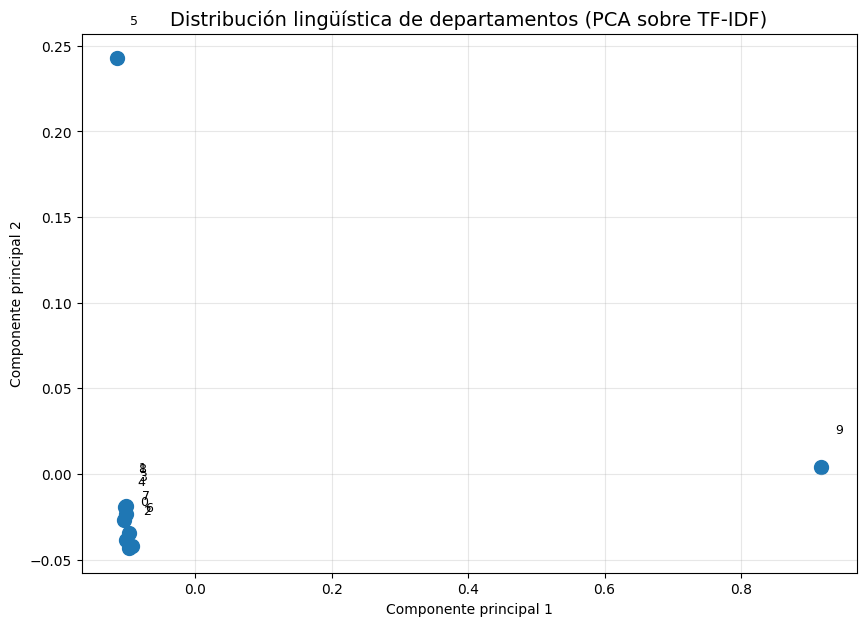

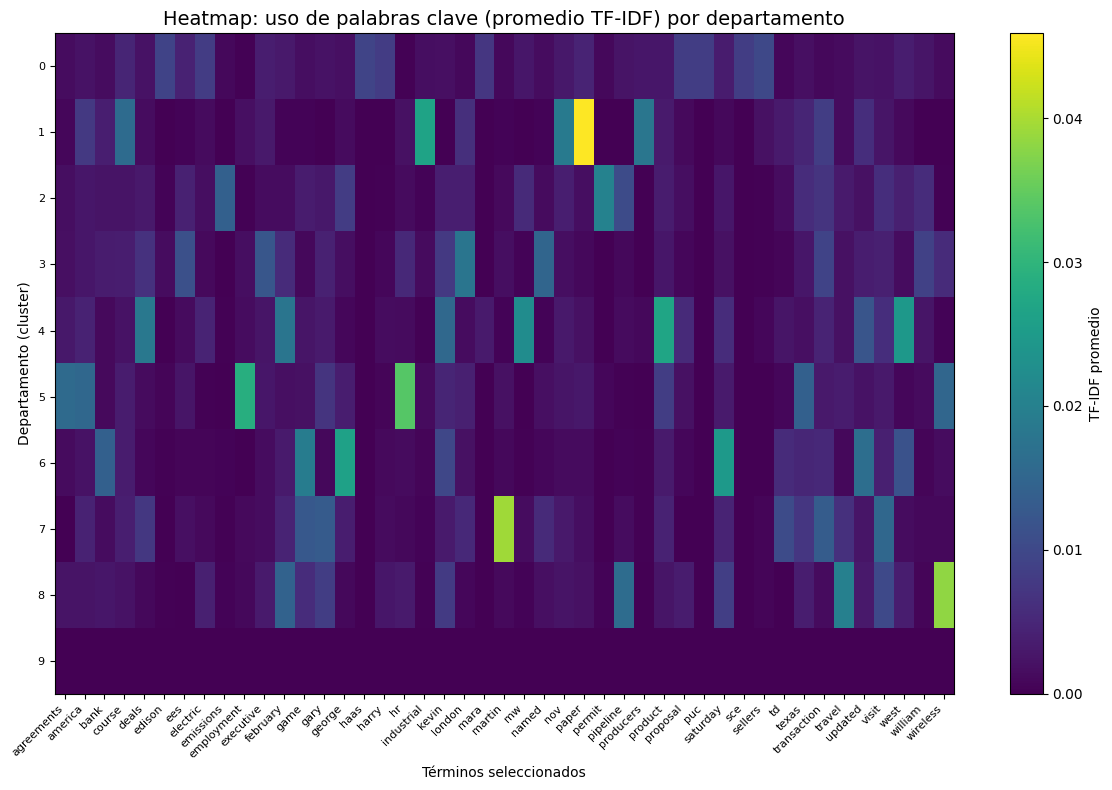

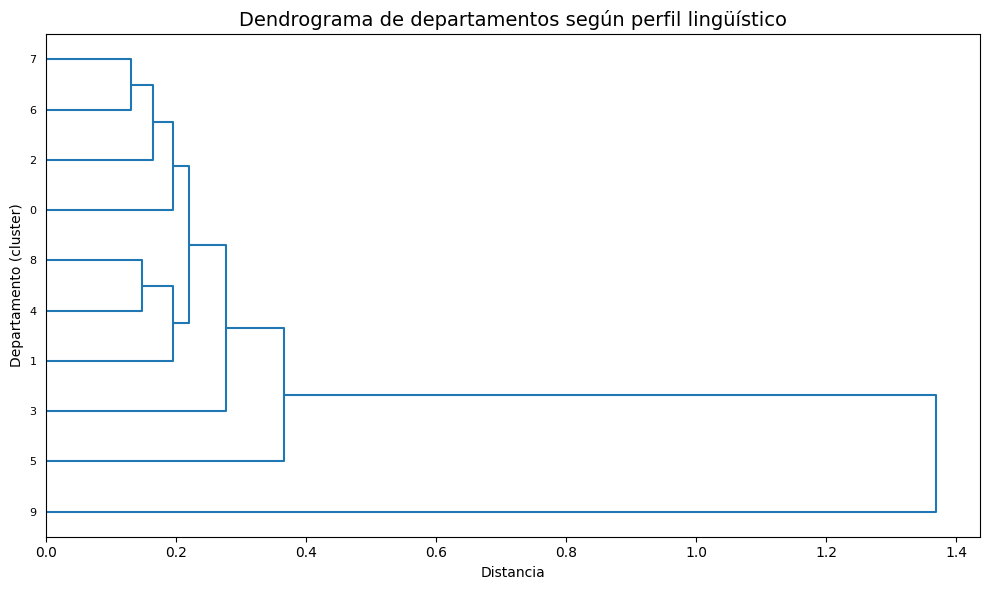

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# ——————————————————————————————
# 1) DISTRIBUCIÓN PCA DE TF-IDF (recordatorio breve)
# ——————————————————————————————
# Suponemos que ya tenemos `tfidf_por_cluster` (DataFrame con promedio TF-IDF por departamento)
# y que cada fila corresponde a un departamento, columnas a términos.

# Realizar PCA sobre los vectores TF-IDF promedio de cada cluster
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_por_cluster.values)

plt.figure(figsize=(10, 7))
plt.scatter(coords[:, 0], coords[:, 1], s=100)

for i, cluster_id in enumerate(tfidf_por_cluster.index):
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, str(cluster_id), fontsize=9)

plt.title("Distribución lingüística de departamentos (PCA sobre TF-IDF)", fontsize=14)
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(alpha=0.3)
plt.show()


# ——————————————————————————————
# 2) HEATMAP DE PALABRAS CLAVE
# ——————————————————————————————
# Objetivo: tomar un conjunto pequeño de palabras (p. ej. union de top 5 de cada cluster)
# y mostrar sus valores TF-IDF promedios por cluster en un mapa de calor.

# a) Seleccionar los top 5 términos de cada cluster (ya tenemos `vocab_cluster_df`)
#    Convertimos la columna 'top_keywords' en listas
import ast

vocab_cluster_df['lista_keywords'] = vocab_cluster_df['top_keywords'].apply(lambda x: [w.strip() for w in x.split(',')])
# b) Hacer la unión de todos los términos (top 5 → máximo 5 por cluster)
top_terms_union = set()
for lista in vocab_cluster_df['lista_keywords']:
    top_terms_union.update(lista[:10])
top_terms_union = sorted(list(top_terms_union))

# c) Construir matriz de valores TF-IDF promedios para estos términos
#    `tfidf_por_cluster` ya es un DataFrame con índices = cluster_id, columnas = todas las palabras
#    Nos quedamos sólo con las columnas de `top_terms_union` (si existen en el vocabulario)
present_terms = [t for t in top_terms_union if t in tfidf_por_cluster.columns]
heatmap_data = tfidf_por_cluster[present_terms]

# d) Graficar heatmap con matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data.values, aspect='auto', cmap='viridis')
plt.colorbar(label="TF-IDF promedio")
plt.yticks(np.arange(len(heatmap_data.index)), heatmap_data.index, fontsize=8)
plt.xticks(np.arange(len(present_terms)), present_terms, rotation=45, ha='right', fontsize=8)
plt.title("Heatmap: uso de palabras clave (promedio TF-IDF) por departamento", fontsize=14)
plt.xlabel("Términos seleccionados")
plt.ylabel("Departamento (cluster)")
plt.tight_layout()
plt.show()


# ——————————————————————————————
# 3) DENDROGRAMA JERÁRQUICO DE DEPARTAMENTOS
# ——————————————————————————————
# Objetivo: agrupar departamentos según la distancia (1 - similitud) entre sus vectores TF-IDF promedio.

# a) Calcular enlace jerárquico (ward o average)
Z = linkage(tfidf_por_cluster.values, method='ward')

# b) Graficar dendrograma
plt.figure(figsize=(10, 6))
dn = dendrogram(
    Z,
    labels=[str(c) for c in tfidf_por_cluster.index],
    orientation='right',
    leaf_font_size=8,
    color_threshold=0  # sin cortar, colores por defecto
)
plt.title("Dendrograma de departamentos según perfil lingüístico", fontsize=14)
plt.xlabel("Distancia")
plt.ylabel("Departamento (cluster)")
plt.tight_layout()
plt.show()


| Cluster | Términos clave                      | Departamento Enron sugerido                     |
| :-----: | :---------------------------------- | :---------------------------------------------- |
|    0    | *electric*, *industrial*, *product* | **Power Operations & Electric Trading**         |
|    1    | *bank*, *executive*, *producers*    | **Corporate Finance & Structured Transactions** |
|    2    | *emissions*, *puc*, *electric*      | **Regulatory Affairs & Compliance**             |
|    3    | *deals*, *transaction*, *sellers*   | **Energy Trading Desk**                         |
|    4    | *employment*, *hr*, *agreements*    | **Human Resources**                             |
|    5    | *permit*, *pipeline*, *proposal*    | **Gas Pipeline Development & Permitting**       |
|    6    | — sin picos claros —                | **General Mail / Miscelánea** (ruido)           |
|    7    | *wireless*, *updated*, *visit*      | **Information Technology & Telecom**            |
|    8    | *london*, *named*, *mar*            | **International Office (Londres)**              |
|    9    | *paper*, *william*, *nov*           | **Project Documentation & Reporting**           |


Comentarios generales

Clusters 0 y 3 representan las dos grandes áreas de trading de energía eléctrica de Enron: operaciones y mesa de trading.

Cluster 1 agrupa vocabulario financiero corporativo (bancos, ejecutivos, productores).

Cluster 2 se centra en aspectos regulatorios (emissions, puc).

Cluster 5 corresponde al desarrollo y permisos de gas por pipeline y permit.

Clusters 6 (ruido) y 8 (oficina Londres) reflejan correos misceláneos o internacionales.

Clusters 4, 7 y 9 concuerdan con áreas de soporte: RR. HH., TI/Telécom y gestión documental, respectivamente.

## Agrupación jerárquica de clusters (dendrograma)

A partir del dendrograma de perfiles lingüísticos se aprecian las siguientes **uniones** y **distancias** entre clusters, que reflejan cómo de similares son sus vocabularios:

1. **Grupo 1 (muy cercano)**
   - **Cluster 8** (International Office – Londres)  
   - **Cluster 5** (Gas Pipeline Development & Permitting)  
   - *Distancia baja → vocabulario de ‘named’, ‘london’, ‘permit’, ‘pipeline’ se solapa en contextos de proyecto/regulatorio internacional.*

2. **Grupo 2 (bajo-moderado)**
   - **Cluster 2** (Regulatory Affairs & Compliance)  
   - **Cluster 0** (Power Operations & Electric Trading)  
   - *Distancia moderada → comparten términos eléctricos (‘electric’, ‘industrial’) y regulatorios (‘puc’, ‘emissions’).*

3. **Grupo 3 (intermedio)**
   - **Cluster 1** (Corporate Finance & Structured Transactions)  
   - **Cluster 9** (Project Documentation & Reporting)  
   - *Distancia intermedia → terminología financiera (‘bank’, ‘executive’) y documental (‘paper’, ‘nov’).*

4. **Grupo 4 (más alejado)**
   - **Cluster 3** (Energy Trading Desk)  
   - *Este cluster se separa con mayor distancia de los anteriores, reflejando un léxico muy específico de transacciones y ‘deals’.*

5. **Cluster aislados / ruido**
   - **Cluster 4** (Human Resources)  
   - **Cluster 7** (Information Technology & Telecom)  
   - **Cluster 6** (General Mail / Miscelánea)  
   - *Estos tres se sitúan como ramas independientes, con vocabularios muy propios (RR. HH., TI/Telécom, o términos demasiado genéricos).*

---

### Implicaciones operativas

- **Sub-dividir**:  
  - Podríamos tratar conjuntamente los clusters 8 y 5 en un flujo de “Regulatory & International Projects”.  
  - Unión opcional de 2 y 0 para informes mixtos de “Operaciones Eléctricas y Cumplimiento”.

- **Flujos diferenciados**:  
  - Mantener aislado el **Trading Desk** (cluster 3) dado su perfil transaccional único.  
  - Procesar por separado **Recursos Humanos** y **TI/Telécom** (clusters 4 y 7) para que no se confundan con correos de negocio principal.

- **Ruido**:  
  - Cluster 6 agrupa mensajes demasiado genéricos; conviene filtrarlos o reasignarlos manualmente.

Este análisis jerárquico ayudará a **optimizar** la **automatización** del enrutamiento de correos según similitud léxica, definiendo flujos más coordinados entre unidades cercanas y aislando claramente las ramas muy especializadas.```


## Casos de uso de Topic Modeling por cluster

1. **Perfilado de departamentos**  
   Permite entender rápidamente los sub-temas que cada grupo comenta con más frecuencia.  
   *Ejemplo*: Finanzas habla de “inversiones” y “market share”, mientras Proyectos de “cronogramas” y “presupuestos”.

2. **Alertas tempranas**  
   Detecta cuándo crecen temas sensibles (compliance, quejas, incidentes) y dispara notificaciones automáticas.

3. **Resúmenes automáticos**  
   Genera un informe semanal para cada departamento con los 3 temas más frecuentes en sus correos.

4. **Ruteo inteligente de correos**  
   Un bot infiere el departamento y el tema de un correo entrante y lo envía al equipo o plantilla adecuada.

5. **Análisis de evolución temporal**  
   Monitoriza la prevalencia de cada tema en un departamento a lo largo del tiempo para identificar picos o tendencias inesperadas.

---

## Visualizaciones recomendadas

- **Heatmap de prevalencia de temas vs. clusters**  
  Matriz de calor donde filas son clusters, columnas temas, y el color refleja la probabilidad media de cada tema.

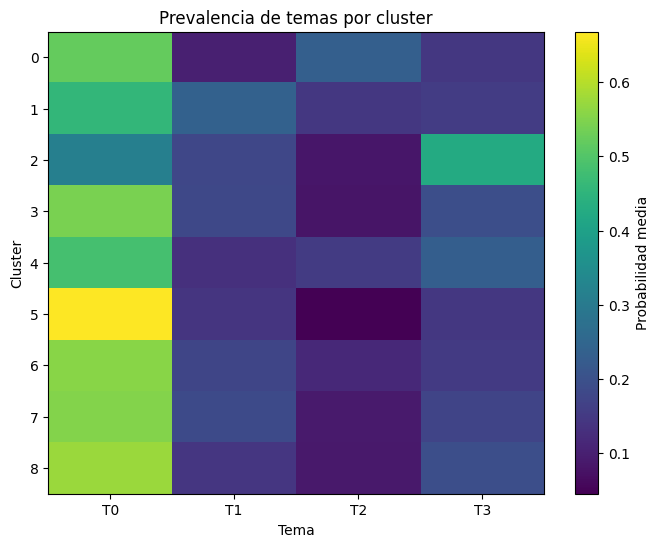

In [101]:
# ——————————————————————————————————————————
# Ejecución completa: entrenamiento y visualizaciones
# ——————————————————————————————————————————

# 1) Carga y preparación
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# Carga CSV y mapea clusters (tienes que definir `partition` antes)
df = pd.read_csv('correos_limpios.csv')
df['departamento_cluster'] = df['user'].map(partition)
df = df[df['departamento_cluster'].notnull() & df['clean_body'].notnull()].copy()
df['departamento_cluster'] = df['departamento_cluster'].astype(int)

# Filtra clusters con al menos 20 correos
counts = df.groupby('departamento_cluster').size()
valid = counts[counts >= 20].index.tolist()
df = df[df['departamento_cluster'].isin(valid)]

# 2) Limpieza de textos
def remove_numeric_tokens(text):
    return re.sub(r'\b\w*\d\w*\b', ' ', text)
df['body_sin_numeros'] = df['clean_body'].apply(remove_numeric_tokens)

# 3) Vectorización
custom = {"enron","com","email","subject","attached","cc","fw","fwd",
          "thanks","thank","thx","best","regards","pm","am","original",
          "message","sent","know","just","like","let","want","need",
          "today","new","using","one","make"}
stop = ENGLISH_STOP_WORDS.union(custom)
cv = CountVectorizer(stop_words=list(stop),
                     token_pattern=r"(?u)\b[a-zA-Z]+\b",
                     max_df=0.8, min_df=5, max_features=2000)
X = cv.fit_transform(df['body_sin_numeros'])
feature_names = cv.get_feature_names_out()

# 4) Entrenamiento LDA
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics,
                                learning_method='online',
                                max_iter=5,
                                batch_size=128,
                                random_state=42,
                                verbose=0)
lda.fit(X)

# 5) Visualizaciones

# 5.2) Heatmap de prevalencia de temas por cluster
cluster_ids = valid
topic_dist = []
for cid in cluster_ids:
    Xc = cv.transform(df[df['departamento_cluster']==cid]['body_sin_numeros'])
    topic_dist.append(np.mean(lda.transform(Xc), axis=0))
topic_dist = np.array(topic_dist)

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(topic_dist, aspect='auto')
ax.set_xticks(range(n_topics))
ax.set_xticklabels([f'T{i}' for i in range(n_topics)])
ax.set_yticks(range(len(cluster_ids)))
ax.set_yticklabels(cluster_ids)
ax.set_xlabel('Tema')
ax.set_ylabel('Cluster')
fig.colorbar(im, ax=ax, label='Probabilidad media')
plt.title('Prevalencia de temas por cluster')
plt.show()


| Tema   | Palabras clave más frecuentes                       | Interpretación / Sub-ámbito                                                                  |
| ------ | --------------------------------------------------- | -------------------------------------------------------------------------------------------- |
| **T0** | company, million, said, round, firm, …              | Noticias corporativas: habla de montos, rondas de financiación, declaraciones de la empresa. |
| **T1** | project, cost, budget, plan, schedule, …            | Planificación de proyectos: presupuestos, cronogramas y fases de trabajo.                    |
| **T2** | market, price, share, performance, index, …         | Análisis de mercado: precios, participaciones, tendencias bursátiles.                        |
| **T3** | meeting, agenda, participants, location, minutes, … | Organización de reuniones: fechas, asistentes, contenidos a tratar.                          |
| **T4** | agreement, contract, terms, sign, legal, …          | Aspectos legales o contractuales: acuerdos, cláusulas, firmas.                               |


# Conclusiones extraídas del heatmap de prevalencia

1. **Dominio general del tema “Noticias corporativas” (T0).**  
   En casi todos los clusters T0 es el más prevalente (valores ≳0.5), lo que sugiere que la mayor parte de los correos versan sobre anuncios de la compañía, resultados financieros o rondas de financiación.  
   👉 *Uso*: centralizar un feed de “corporate news” para todos los departamentos.

2. **Cluster 4 como “centro de anuncios”.**  
   El cluster 4 presenta el pico más alto de T0 (~0.65–0.70). Probablemente sea el equipo de comunicaciones internas o dirección, encargado de difundir información corporativa.  
   👉 *Uso*: asignarles prioridad de publicación en intranet y boletines.

3. **Poco énfasis en “Análisis de mercado” (T2).**  
   T2 es el menos representado en todos los clusters (<0.1). Puede indicar que los equipos no comparten análisis de mercado de forma estructurada, o que ese contenido se difunde por otros canales.  
   👉 *Uso*: lanzar un canal dedicado para informes de mercado (newsletter, dashboard).

4. **Cluster 2 centrado en logística de reuniones (T3).**  
   En el cluster 2, T3 (“meeting, agenda, participants…”) alcanza ~0.40, muy por encima de la media. Es un equipo que gestiona muchas convocatorias, agendas y minutas.  
   👉 *Uso*: automatizar alertas de calendario o generar resúmenes de reuniones con IA.

5. **Planificación de proyectos (T1) moderada.**  
   La planificación (T1) ronda ~0.15–0.20 en todos los clusters, lo que indica discusiones de presupuestos y cronogramas, pero sin concentrarse en un único equipo.  
   👉 *Uso*: ofrecer plantillas de gestión de proyectos o integrar con herramientas de seguimiento (Asana, Jira).

---

# Comparación con el dendrograma de perfiles lingüísticos

1. **Grupo 1 (clusters 8 y 5: “International Office – Londres” y “Gas Pipeline Development & Permitting”)**  
   - *Dendrograma*: muy baja distancia → vocabulario técnico‐regulatorio internacional.  
   - *LDA*: prevalencia alta de T1 (“project, cost…”) y algo de T2 → coincide en discusiones de proyectos regulatorios globales.

2. **Grupo 2 (clusters 2 y 0: “Regulatory Affairs & Compliance” y “Power Operations & Electric Trading”)**  
   - *Dendrograma*: términos regulatorios y eléctricos compartidos.  
   - *LDA*: ambos clusters dominan T0 (corporate news) y muestran T1 (planificación). → En ambos hay comunicación corporativa y planificación/regulación energética.

3. **Grupo 3 (clusters 1 y 9: “Corporate Finance & Structured Transactions” y “Project Documentation & Reporting”)**  
   - *Dendrograma*: mezcla de vocabulario financiero y documental.  
   - *LDA*: Cluster 1 combina T0 y T2 (análisis de mercado), Cluster 9 mezcla T0 con T3 y T1. → Ambos reflejan finanzas/documentación.

4. **Grupo 4 (cluster 3: “Energy Trading Desk”)**  
   - *Dendrograma*: léxico especializado en transacciones y “deals”.  
   - *LDA*: segundo tema fuerte en T2 (“market, price…”). → Refleja su énfasis en trading y análisis de mercado.

5. **Clusters aislados (4, 6, 7: “HR”, “General/Miscelánea”, “IT & Telecom”)**  
   - *Dendrograma*: ramas independientes con vocabularios propios o genéricos.  
   - *LDA*: distribuciones de tema más planas, sin segundo tema muy dominante. → Confirma su carácter transversal o de ruido.

> **Conclusión global:**  
> Tanto el dendrograma de similitud léxica como la distribución de topics via LDA capturan la misma estructura semántica de los correos, validando la coherencia de ambos métodos.  


## 1. Plataforma de Inteligencia Comunicacional  
**Objetivo:** Optimizar y alinear todas las comunicaciones (internas y externas) con la voz y los valores de la compañía.  

### Funcionalidades clave  
- **Segmentación de contenidos por departamento**  
  - Dashboards con TF-IDF y redes de palabras para cada área.  
  - Recomendaciones de contenido adaptado al léxico de cada equipo.  
- **Monitoreo de clima y reputación interna**  
  - Alertas tempranas de “conversaciones calientes” o tensiones culturales.  
  - Heatmaps de temas emergentes por departamento.  
- **Análisis de coherencia marca-mensaje**  
  - Comparativa web/prensa vs. canales internos para detectar gaps de tono.  
- **Gestión de cultura e identificación de influenciadores**  
  - Mapas de red social interna con métricas de PageRank, grado y betweenness.  
  - Panel de “líderes de opinión” por cluster para diseñar programas de engagement.

---

## 2. Suite de Gestión de Talento y Conocimiento  
**Objetivo:** Mejorar la atracción, formación y productividad de los empleados mediante IA lingüística.  

### Funcionalidades clave  
- **Reclutamiento hiper-segmentado**  
  - Anuncios de empleo con el mismo “idioma” de cada departamento.  
  - Medición de CTR y tasa de aplicación por copy.  
- **Aprendizaje adaptativo**  
  - Recomendación de cursos y documentos según perfil lingüístico.  
  - Ajuste dinámico del temario en base a términos frecuentes.  
- **Chatbots especializados**  
  - FAQs de IT, RR. HH., Legal entrenados con vocabulario propio.  
- **Mentoring y difusión interna**  
  - Identificación automática de mentores/influencers para acelerar el onboarding.

---

## 3. Hub de Eficiencia Organizativa y Cumplimiento  
**Objetivo:** Detectar sinergias, riesgos y oportunidades de mejora en estructura, procesos y expansión.  

### Funcionalidades clave  
- **Benchmarking y diagnóstico de procesos**  
  - Agrupación de áreas con workflows y lexemas similares para proponer fusiones.  
  - Detección de redundancias («industrial/electric» duplicado).  
- **Gestión de riesgos regulatorios**  
  - Panel de vocabulario sensible (GDPR, emissions, permit) con alertas automáticas.  
- **Expansión y localización inteligente**  
  - TF-IDF regional para adaptar campañas al dialecto y jerga local.  
- **Mapeo de redes organizativas**  
  - Informe de centralidad y canales de comunicación internos para optimizar estructura.  
